# Customer Lifetime value & RFM analysis suing ML

- Tutorial [here](https://youtu.be/s-32u6XdY7c?si=ujA6hWThwc71u5OU)
- Dataset [here](https://www.kaggle.com/datasets/woody123/cdnow-dataset/data)


## Business Problem
Non-contractual purchase relationship

- Covers New Customers that never made a purchase before
    - Cohort analysis
- Goals: understand which customers to focus on
    - Prediction task
    - How much will they spend in the future (90 days ahead)
    - What probability will they make another purchase in the future
- 3 main questions:
    - Which customers have the highest spend probability in next 90-days
    - Which customers have recently purcheadsed but are unlikely to buy
        - (Died and) Survival analysis
    - Which customers were predicted to purchase but didn't (missed opportinities)

- Customers Lifetime Value (CLV)
    - CLV is the profit from estimated by the future relationship with a customer.
    - There are many different approaches to modeling CLV.

## ML approach
1. Subset a Cohort
    - A cohort is a group of customers that all start at the same time.
2. Temporal splitting
    - Use future information to develop targets:
    - Amount spent in next 90-days
    - Spend flag (true/false)
    - RFM method
        - Recency
            - How recently did the customer purchase?
        - Frequency
            - How often do they purchase?
        - Monetary value
            - How much do they spend?
                - price_sum
                - price_mean
3. RFM Features (method) (Feature Engineering)
    - Recency
        - How recently did the customer purchase?
    - Frequency
        - How often do they purchase?
    - Monetary value
        - How much do they spend?
        - ``price_sum``
        - ``price_mean``
4. 2 predictive models
    - Model 1: predict how much a customer will spend in next N-days (regression)
    - Model 2: what probability a customer will purchase in next N-days (classification)

# Importing data

In [3]:
import os
import numpy as np
import pandas as pd
import joblib
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

dir = os.getcwd()

In [4]:
pn.options.dpi = 300

In [5]:
DSet = pd.read_csv(dir+'\\cdnow.csv')

In [8]:
DSet.head()

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76


In [11]:
DSet.describe()

,Unnamed: 0,customer_id,quantity,price
count,69659.000000,69659.000000,69659.000000,69659.000000
mean,34829.000000,11470.854592,2.410040,35.850581
std,20108.965538,6819.904848,2.333924,35.551864
min,0.000000,1.000000,1.000000,0.000000
25%,17414.500000,5506.000000,1.000000,14.490000
50%,34829.000000,11410.000000,2.000000,25.980000
75%,52243.500000,17273.000000,3.000000,43.700000
max,69658.000000,23570.000000,99.000000,932.230000


In [13]:
DSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   69659 non-null  int64  
 1   customer_id  69659 non-null  int64  
 2   date         69659 non-null  object 
 3   quantity     69659 non-null  int64  
 4   price        69659 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.7+ MB


In [15]:
DSet['customer_id'].value_counts()

customer_id
14048    217
7592     201
7983     149
22061    143
3049     117
        ... 
10470      1
10474      1
10477      1
10478      1
11786      1
Name: count, Length: 23570, dtype: int64

# Data preparation

In [18]:
DSet = DSet.drop(['Unnamed: 0'], axis=1)

In [20]:
DSet['date'] = pd.to_datetime(DSet['date'], format='%Y-%m-%d')

# COHORT Analysis

Only the customers that have joined at the specific business day

In [23]:
cdnow_first_purchase_tbl = DSet.sort_values(['customer_id', 'date']).groupby('customer_id').first()
cdnow_first_purchase_tbl

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [175]:
cdnow_first_purchase_tbl['date'].min()
#DSet['date'].min()

Timestamp('1997-01-01 00:00:00')

In [173]:
cdnow_first_purchase_tbl['date'].max()
#DSet['date'].max()

Timestamp('1997-03-25 00:00:00')

<Axes: xlabel='date'>

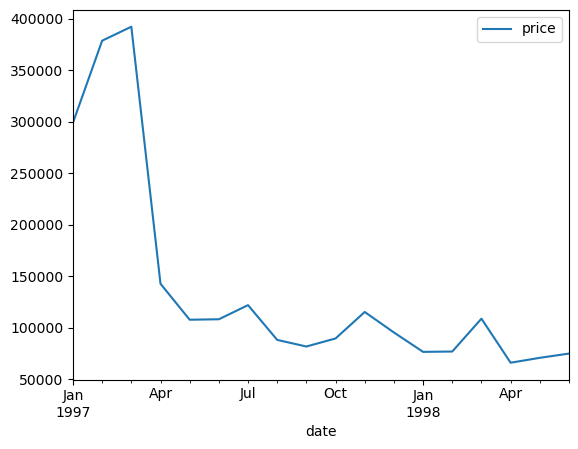

In [29]:
# Visualize: all purchases within cohort

DSet.reset_index().set_index('date')[['price']].resample(rule='MS').sum().plot()

In [31]:
# Visualize: Individual customer purchases
ids = DSet['customer_id'].unique()
ids_selected = ids[0:10]

cdnow_cust_id_subset_df = DSet[DSet['customer_id'].isin(ids_selected)].groupby(['customer_id', 'date']).sum().reset_index()
cdnow_cust_id_subset_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


C:\Users\matia\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\matia\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\matia\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


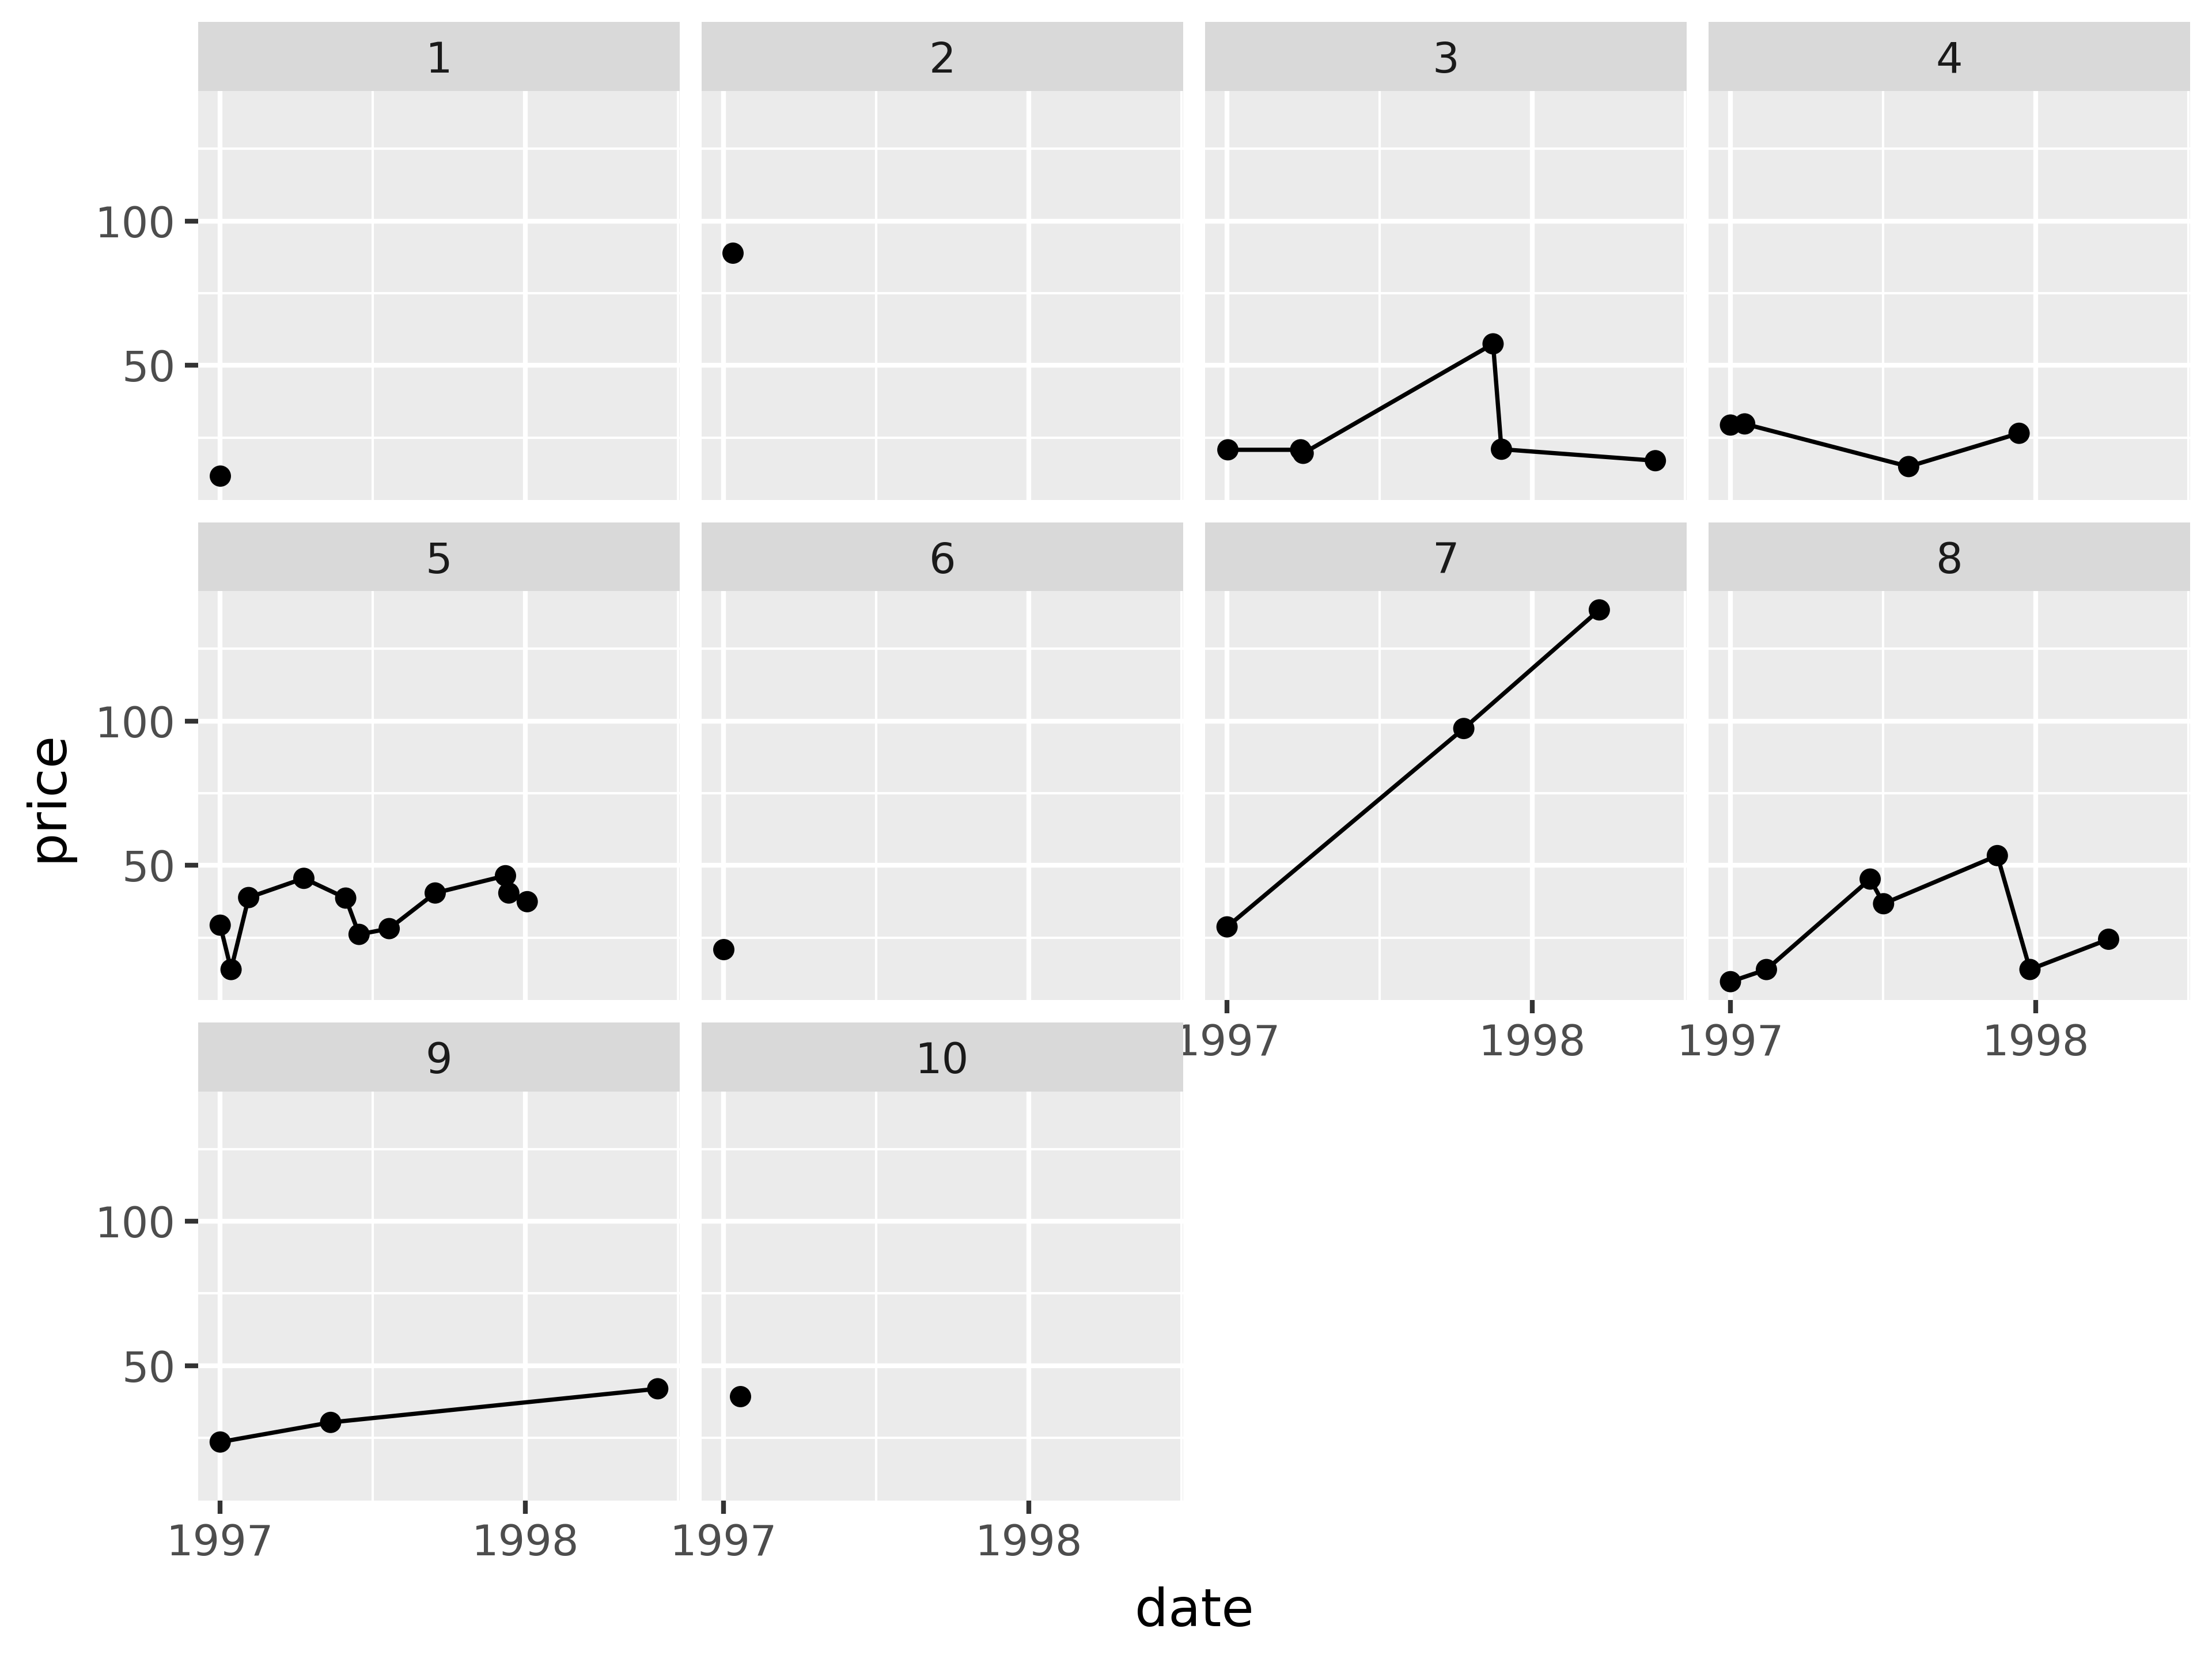

In [33]:
(
pn.ggplot(cdnow_cust_id_subset_df,
          pn.aes(x='date', y='price', group='customer_id') ) + pn.geom_line() + pn.geom_point() + pn.facet_wrap('customer_id') + pn.scale_x_datetime(date_breaks="1 year", date_labels="%Y")
)

- Customer 3 has bought repeatedly, so she is more likely to buy again in the next 90 days.
- Customers 1, 2, 6 and 10 have only bought once.
- Customers 4 and 5 look like they died because they stopped buying.

# Machine Learning

Frame the problem:

- What will the customers spend in the next 90-Days? (Regression)
- What is the probability of a customer to make a purchase in next 90-Days? (Classification)

## Time splitting (stage 1)

In [163]:
n_days = 90
max_date = DSet['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')
cutoff

Timestamp('1998-04-01 00:00:00')

In [62]:
temporal_in_df = DSet[DSet['date'] <= cutoff]
temporal_in_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [64]:
temporal_out_df = DSet[DSet['date'] > cutoff]
temporal_out_df

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97
...,...,...,...,...
69583,23534,1998-05-02,1,10.48
69623,23555,1998-05-01,4,49.96
69624,23555,1998-06-10,2,27.48
69631,23556,1998-06-07,2,28.98


In [177]:
temporal_out_df[ temporal_out_df['customer_id'] == 3 ]

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99


## Feature Engineering (RFM)

- 2-Stage process
- Need to frame the problem
- Need to think about what features to include

In [88]:
# Make Targets from OUT data
# Sums the amount spend after the cutoff (time split) by each customer

targets_df = temporal_out_df.drop(['quantity', 'date'],  axis=1) \
    .groupby('customer_id') \
    .sum() \
    .rename({'price':'spend_90_total'}, axis = 1) \
    .assign(spend_90_flag = 1)


targets_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [151]:
# Make Recency (Date) Features from IN data
# How recent was their most recent purchase?
# Calculates the time between the "time split" (cutoff) and the last customer's purchase date.

max_date_IN = temporal_in_df['date'].max()

recency_features_df = temporal_in_df[['customer_id', 'date']] \
    .groupby('customer_id') \
    .apply(
        lambda x: ( x['date'].max() - max_date_IN )/pd.to_timedelta(1, 'day'), include_groups=False
    ) \
    .to_frame() \
    .set_axis(['recency'], axis=1)


recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [155]:
# Make Frequency (Count) Features from IN data
# Count how many purchase were made before the cutoff (tiem split).

frequency_features_df = temporal_in_df[['customer_id', 'date']] \
    .groupby('customer_id') \
    .count() \
    .set_axis(['frequency'], axis=1)


frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [157]:
# Make Price (Monetary) Features from IN data
# Calcute the sum and mean of all purchase before cutoff, by customer.

price_features_df = temporal_in_df.groupby('customer_id') \
    .aggregate( {'price': ['sum', 'mean']} ) \
    .set_axis(['price_sum', 'price_mean'], axis=1)


price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


## Combine Features

In [165]:
# Combine the last 4 df into one.
# The key to connect them is the customer_id, which is the index in each df.

features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis=1
    ) \
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    ) \
    .fillna(0)
    # ALl the clients that do not have any spend after the cutoff will have a 0.0.


features_df.head(10)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
6,-455.0,1,20.99,20.990000,0.00,0.0
7,-10.0,3,264.67,88.223333,0.00,0.0
8,-3.0,8,197.66,24.707500,0.00,0.0
9,-323.0,2,53.87,26.935000,41.98,1.0


In [167]:
DSet.head(10)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
5,3,1997-04-02,2,19.54
6,3,1997-11-15,5,57.45
7,3,1997-11-25,4,20.96
8,3,1998-05-28,1,16.99
9,4,1997-01-01,2,29.33


# Machine Learning

In [181]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

## Next 90-day spend prediction

In [187]:
y_spend = features_df['spend_90_total']

In [202]:
xgb_reg_spec = XGBRegressor(
    objective = 'reg:squarederror',
    random_state=123
)

xgb_reg_model = GridSearchCV(
    estimator = xgb_reg_spec,
    param_grid = [
        {'learning_rate': [0.01, 0.1, 0.3, 0.5]}
    ],
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5
)

In [204]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.3, 0.5]}],
             scoring='neg_mean_absolute_error')

In [212]:
xgb_reg_model.best_score_

-9.740496026220795

In [208]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [210]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [216]:
predictions_reg = xgb_reg_model.predict(X)
predictions_reg

array([0.7656022, 1.7058846, 8.798372 , ..., 3.4995363, 0.8615987,
       2.1305232], dtype=float32)

## Next 90-days spend probability

In [219]:
y_prob = features_df['spend_90_flag']

In [221]:
xgb_clf_spec = XGBClassifier(
    objective = 'binary:logistic',
    random_state = 123
)

xgb_clf_model = GridSearchCV(
    estimator=xgb_clf_spec,
    param_grid=[
        {'learning_rate': [0.01, 0.1, 0.3, 0.5]}
    ],
    scoring = 'roc_auc',
    refit = True,
    cv = 5
)

In [223]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.3, 0.5]}],
             scoring='roc_auc')

In [225]:
xgb_clf_model.best_score_

0.8356508197983127

In [227]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [229]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [233]:
predictions_clf = xgb_clf_model.predict_proba(X)
predictions_clf

array([[0.79955226, 0.20044775],
       [0.7899691 , 0.21003091],
       [0.6596401 , 0.34035996],
       ...,
       [0.76217   , 0.23782998],
       [0.7955098 , 0.20449017],
       [0.77555573, 0.22444429]], dtype=float32)

## Feature Importance (global)

In [238]:
# Importance | spend amount model

imp_spend_amount_dict = xgb_reg_model.best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain')
imp_spend_amount_dict

{'recency': 126919.296875,
 'frequency': 169224.890625,
 'price_sum': 693907.875,
 'price_mean': 41616.19140625}

In [246]:
imp_spend_amount_df = pd.DataFrame(
        data = {
            'feature':list(imp_spend_amount_dict.keys()),
            'value':list(imp_spend_amount_dict.values())
        }
    ) \
    .assign(
        feature = lambda x:cat.cat_reorder(x['feature'], x['value'])
    )

imp_spend_amount_df

,feature,value
0,recency,126919.296875
1,frequency,169224.890625
2,price_sum,693907.875000
3,price_mean,41616.191406


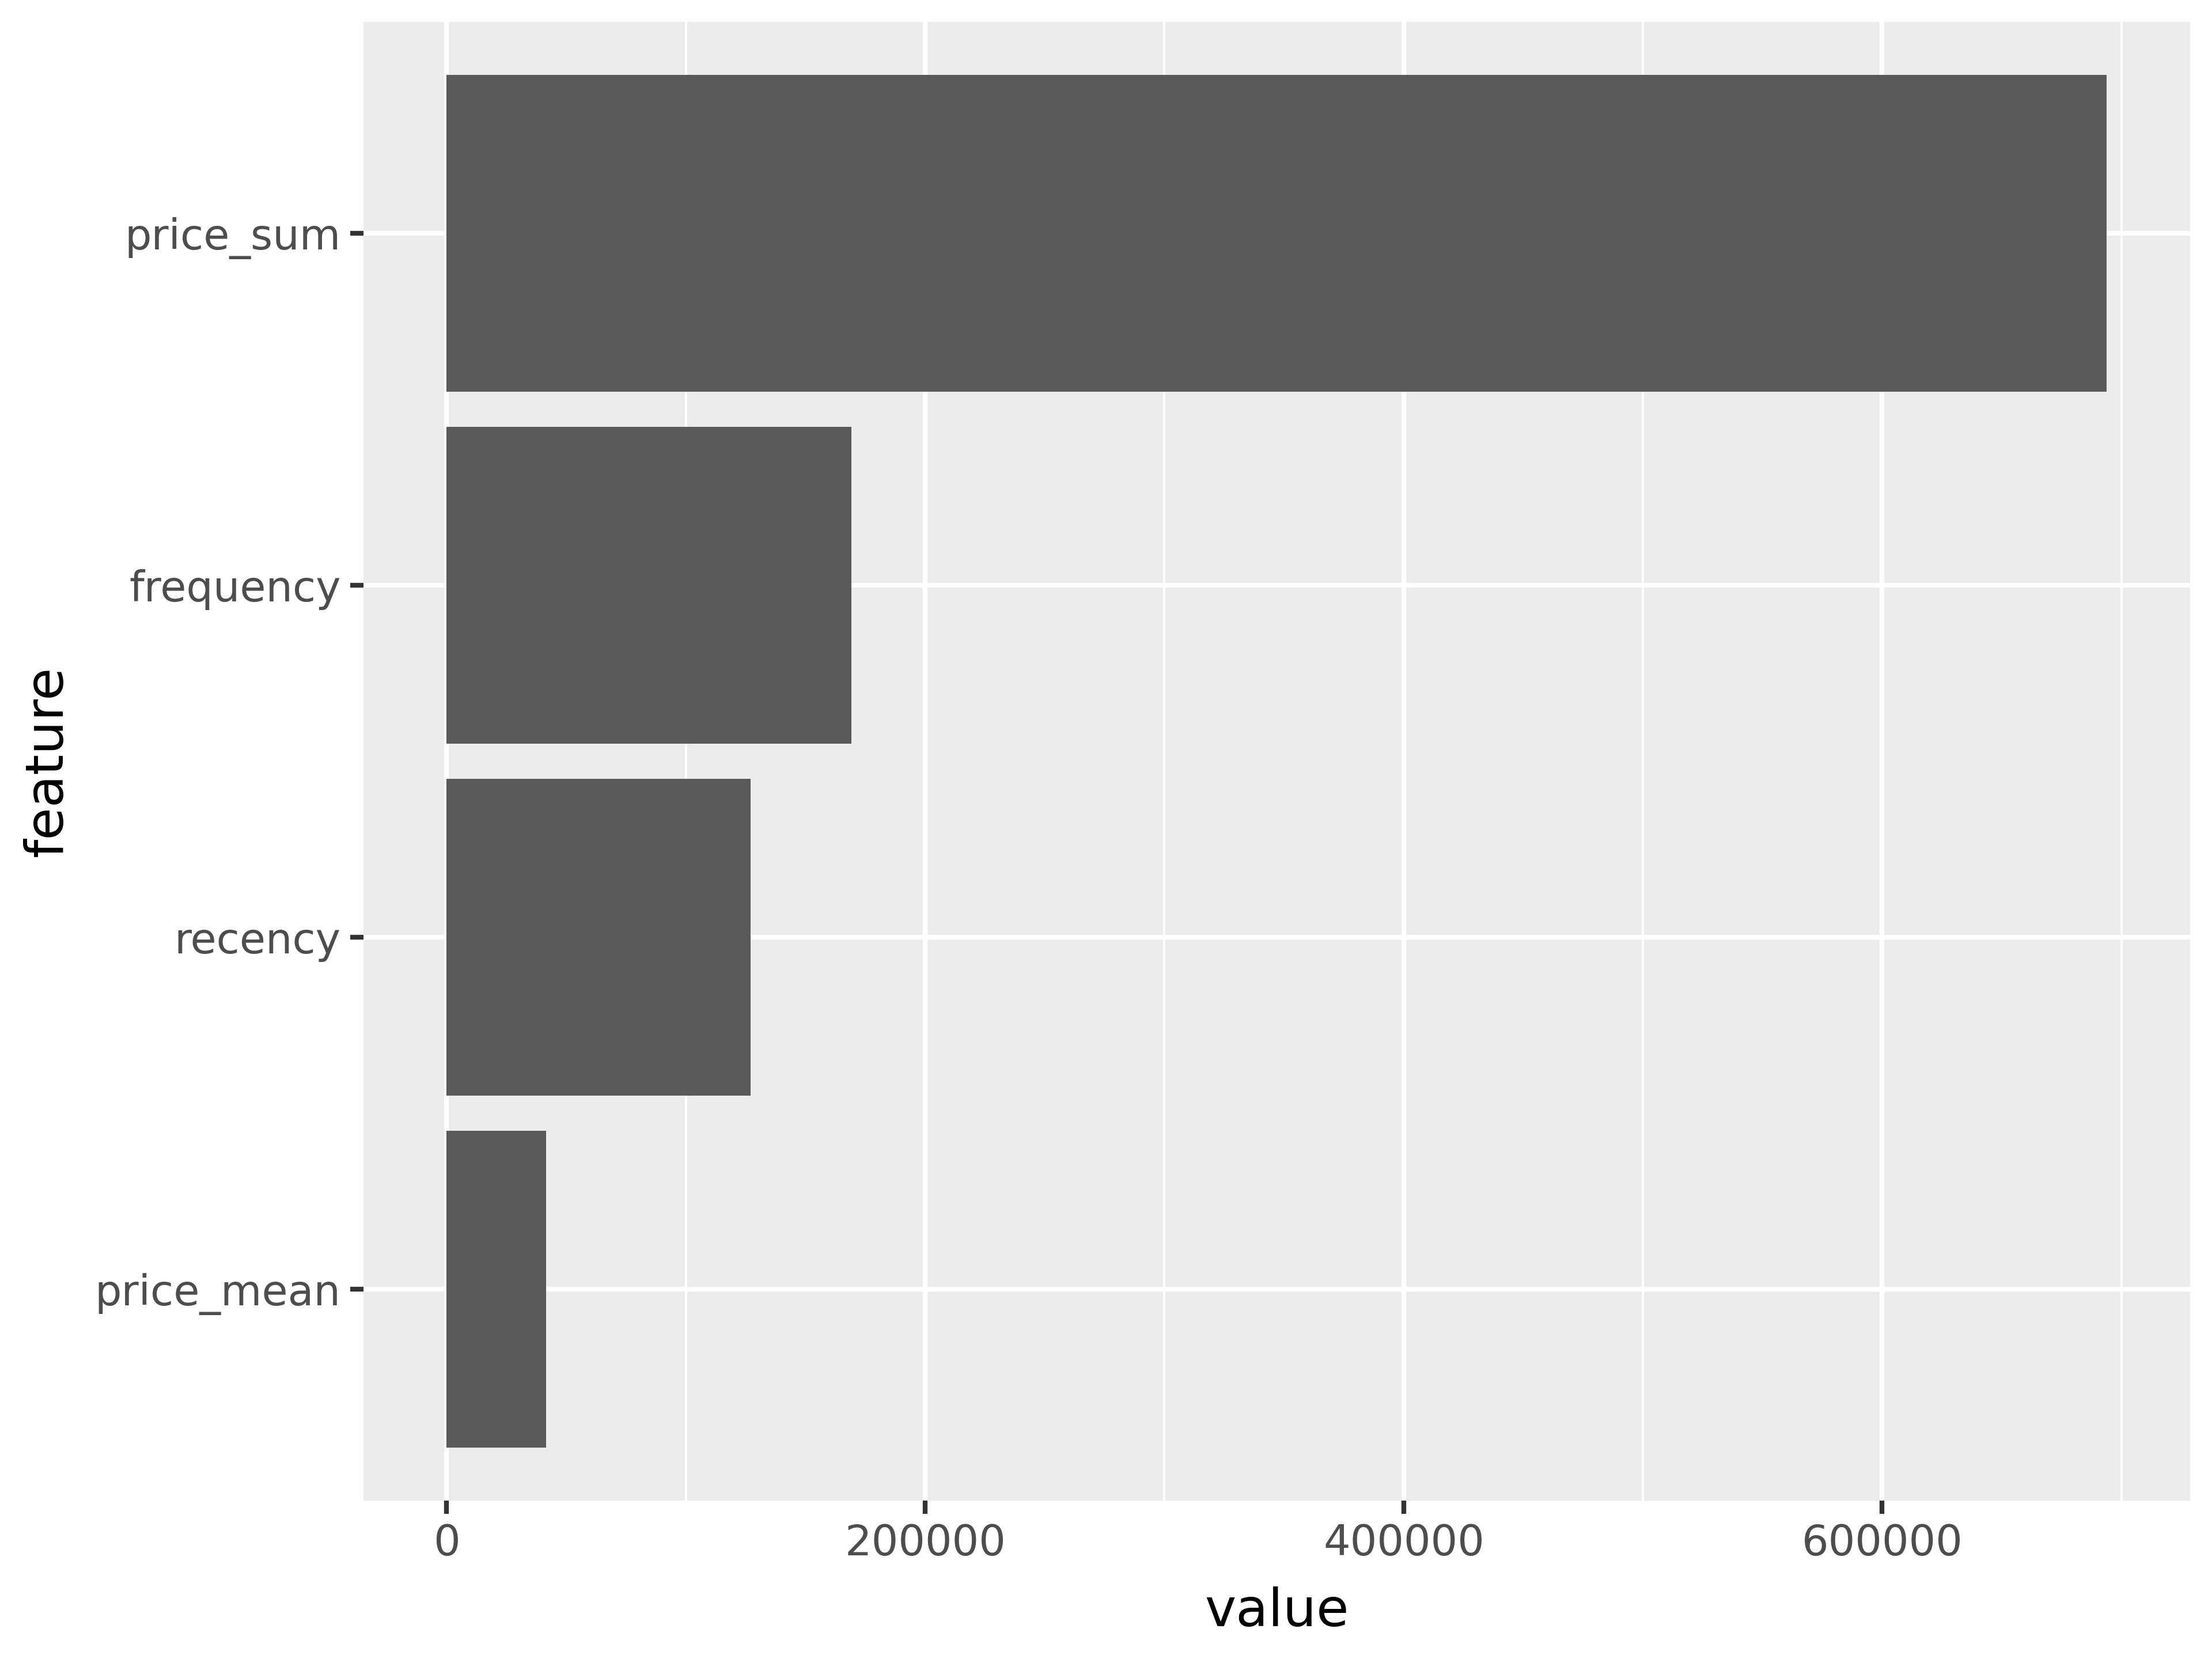

In [258]:
(
pn.ggplot(imp_spend_amount_df,
    pn.aes('feature', 'value') ) + pn.geom_col() + pn.coord_flip()
)

In [264]:
# Importance | spend probability model

imp_spend_prob_dict = xgb_clf_model.best_estimator_ \
    .get_booster() \
    .get_score(importance_type='gain')

imp_spend_prob_dict

{'recency': 73.87841033935547,
 'frequency': 55.64806365966797,
 'price_sum': 2.9473471641540527,
 'price_mean': 3.2425785064697266}

In [266]:
imp_spend_prob_df = pd.DataFrame(
        data = {
            'feature':list(imp_spend_prob_dict.keys()),
            'value':list(imp_spend_prob_dict.values())
        }
    ) \
    .assign(
        feature = lambda x : cat.cat_reorder(x['feature'], x['value'])
    )

imp_spend_prob_df

,feature,value
0,recency,73.878410
1,frequency,55.648064
2,price_sum,2.947347
3,price_mean,3.242579


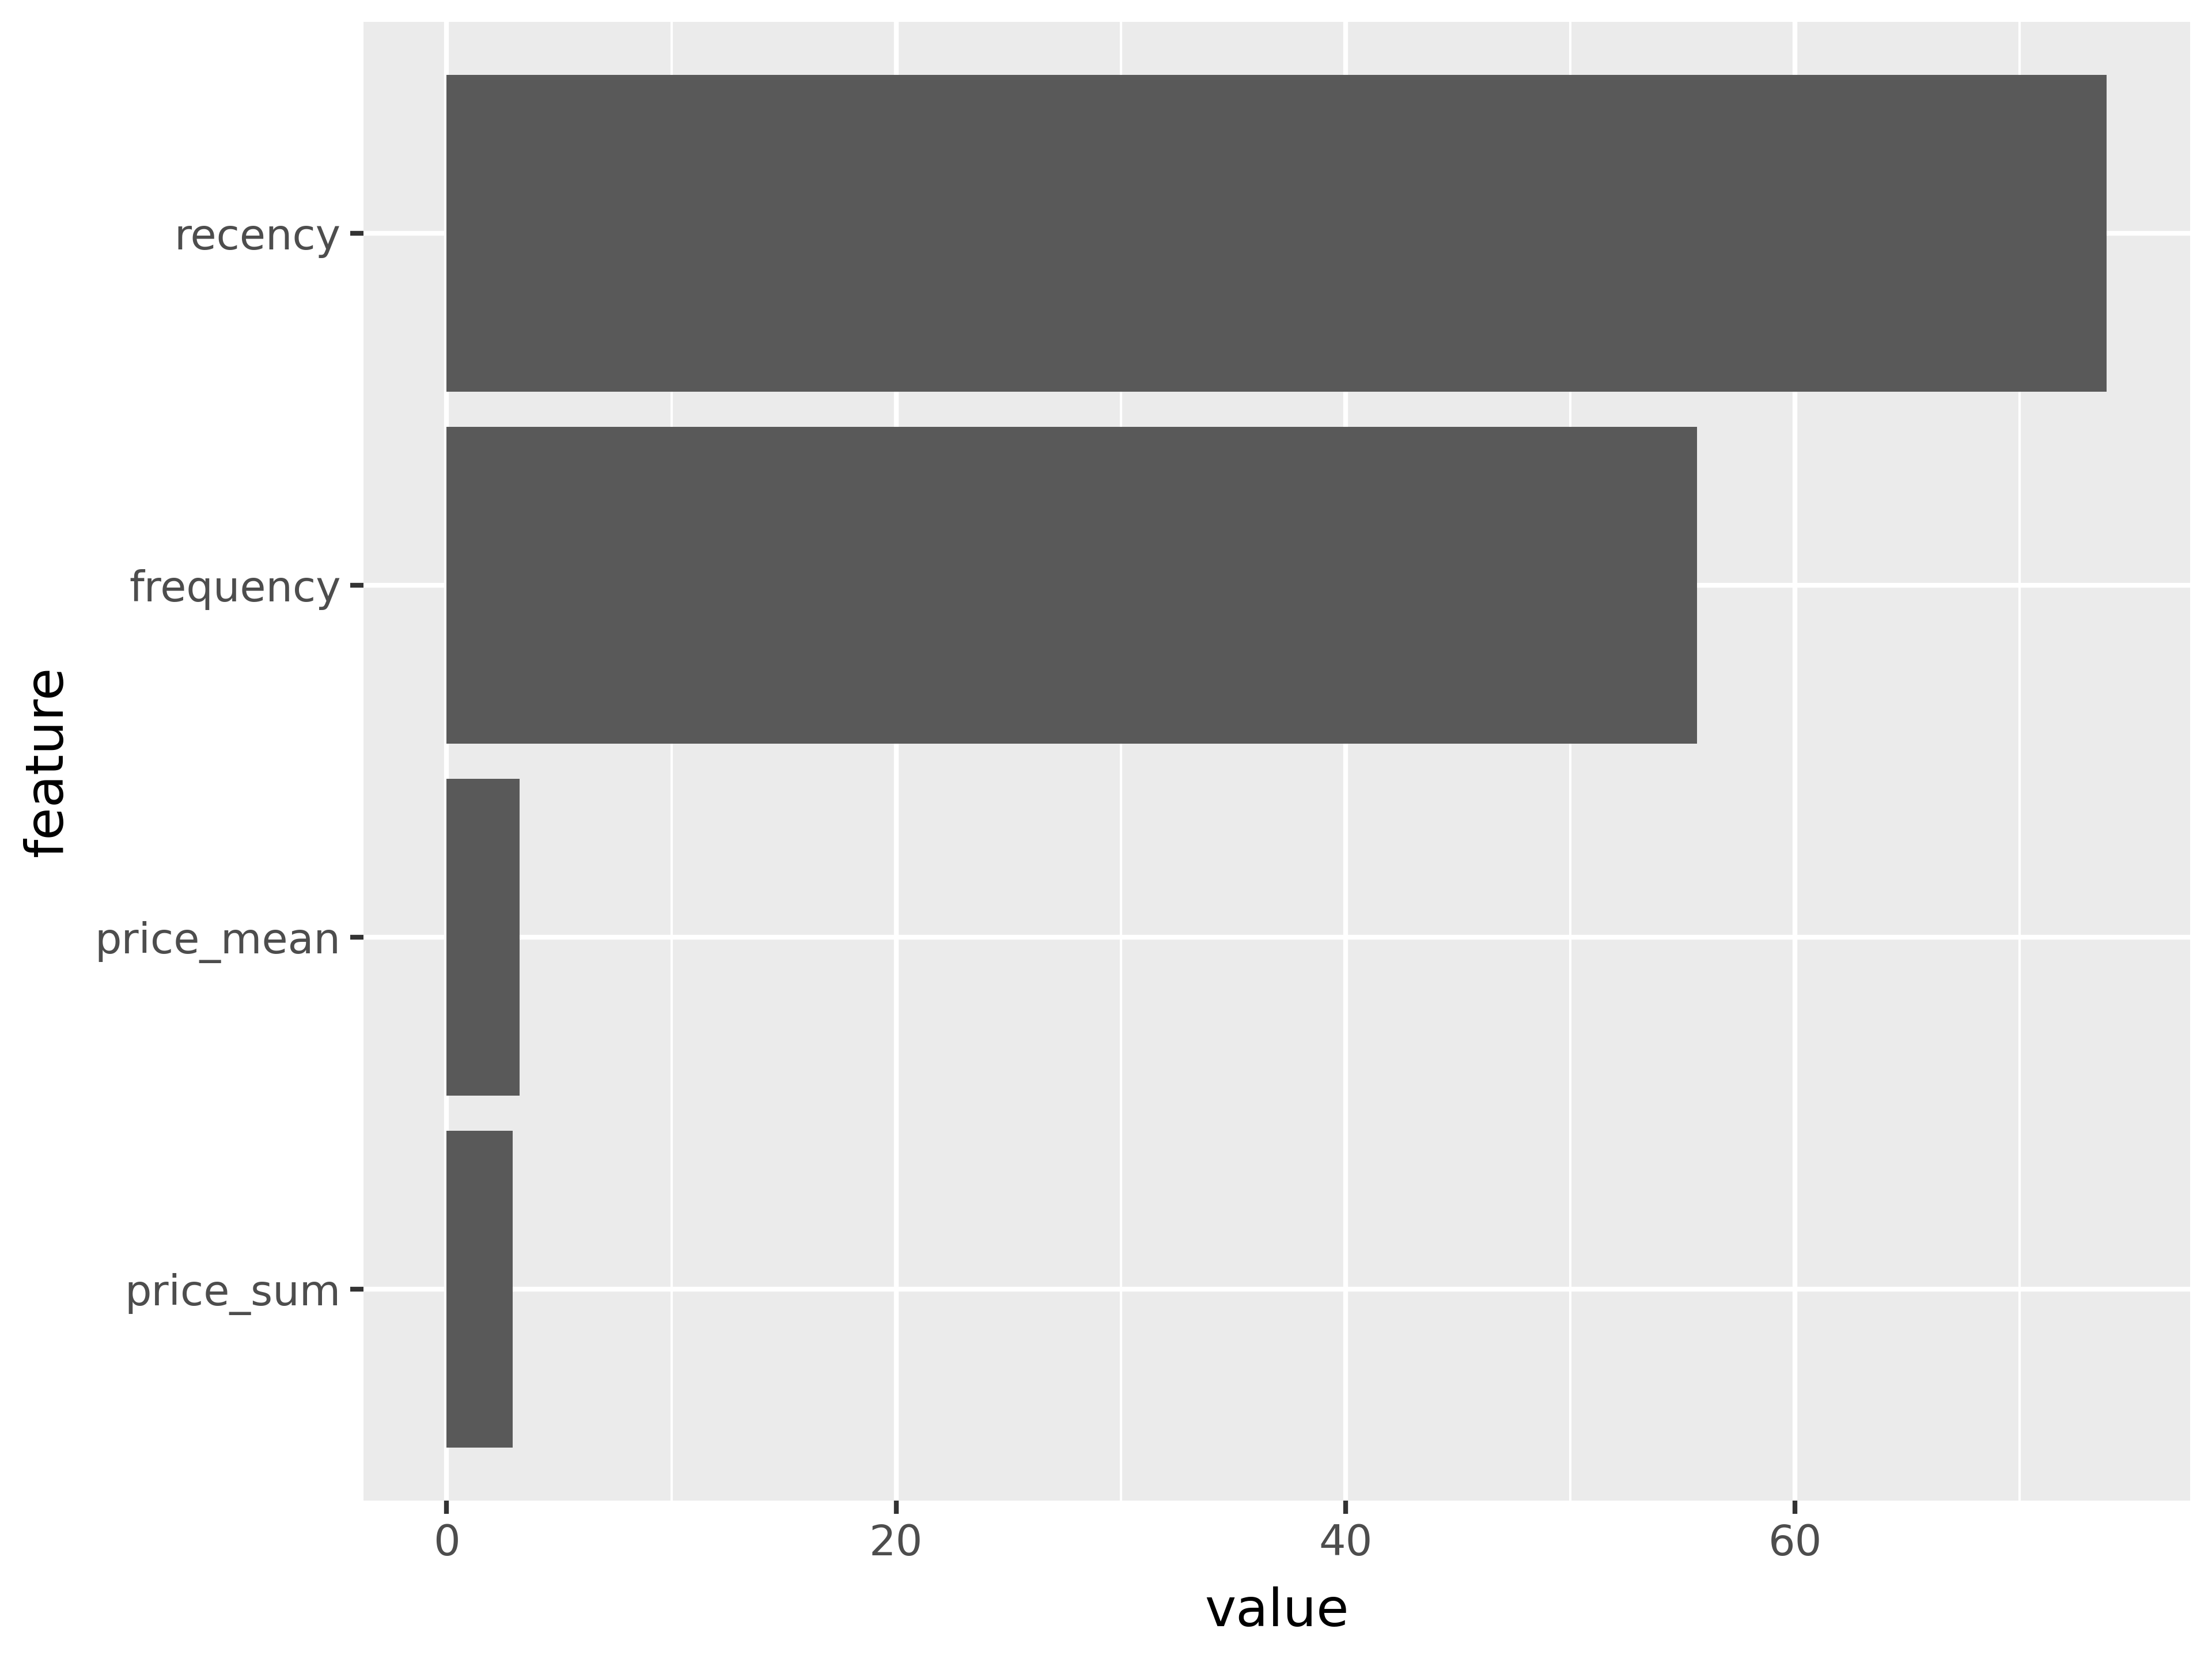

In [269]:
(
pn.ggplot(imp_spend_prob_df,
    pn.aes('feature', 'value') ) + pn.geom_col() + pn.coord_flip()
)

- If the goal of the business is to get more people to spend more money, you need to focus on customers who already spend a lot of money. ("Big Spenders")
- If the goal of the business is to retain customers, you need to focus on the recency and frequency of transactions. ("Don't fall off the vagon")

# Save work

In [276]:
# Save predictions
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features_df.reset_index()
    ],
    axis=1
)
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.765602,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.705885,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.798372,0.340360,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.450706,0.340360,4,-110.0,4,100.50,25.125000,0.00,0.0
4,14.904850,0.553008,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.861599,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.861599,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.499536,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.861599,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [280]:
predictions_df.to_pickle('artifacts/predictions_df.pkl')

In [282]:
pd.read_pickle('artifacts/predictions_df.pkl')

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.765602,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.705885,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.798372,0.340360,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.450706,0.340360,4,-110.0,4,100.50,25.125000,0.00,0.0
4,14.904850,0.553008,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.861599,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.861599,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.499536,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.861599,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [284]:
# Save Importance
imp_spend_amount_df.to_pickle('artifacts/imp_spend_amount_df.pkl')
imp_spend_prob_df.to_pickle('artifacts/imp_spend_prob_df.pkl')

In [286]:
# Save Models
joblib.dump(xgb_reg_model, 'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')

['artifacts/xgb_clf_model.pkl']

In [288]:
# Load models
model = joblib.load('artifacts/xgb_reg_model.pkl')
model.predict(X)

array([0.7656022, 1.7058846, 8.798372 , ..., 3.4995363, 0.8615987,
       2.1305232], dtype=float32)

# How can we use this information

## Which customers have the highest spend probability in next 90-days?

- Target for new products similar to what they have purchased in the past

In [305]:
predictions_df.sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
3048,493.742676,0.782431,3049,-1.0,97,3484.03,35.917835,778.82,1.0
22060,401.252533,0.782431,22061,-2.0,118,3371.80,28.574576,577.10,1.0
12859,176.677963,0.782431,12860,-3.0,30,1389.08,46.302667,457.26,1.0
7273,84.263626,0.782431,7274,-1.0,24,725.78,30.240833,49.48,1.0
498,493.742676,0.782431,499,-3.0,100,3427.55,34.275500,951.00,1.0
...,...,...,...,...,...,...,...,...,...
8601,0.809390,0.200448,8602,-424.0,1,20.99,20.990000,0.00,0.0
8603,0.765602,0.200448,8604,-424.0,1,19.75,19.750000,0.00,0.0
8610,1.453805,0.200448,8611,-423.0,1,56.69,56.690000,0.00,0.0
8611,0.765602,0.200448,8612,-423.0,1,13.97,13.970000,0.00,0.0


## Which customers have recently purchased but are unlikely to buy?

- Incentivize actions to increase probability.
- Provide discounts, encourage referring a friend, nurture by letting them know what's coming.

In [310]:
predictions_df[(predictions_df['recency']>-90) & (predictions_df['pred_prob']<0.30)].sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
14018,61.048737,0.299608,14019,-24.0,2,177.52,88.760,437.52,1.0
8931,16.610754,0.299608,8932,-22.0,2,183.59,91.795,0.00,0.0
17883,4.047980,0.294916,17884,-56.0,2,31.95,15.975,0.00,0.0
19034,4.047980,0.294916,19035,-56.0,2,57.97,28.985,0.00,0.0
14090,4.047980,0.294916,14091,-56.0,2,33.34,16.670,27.87,1.0
...,...,...,...,...,...,...,...,...,...
7365,16.504955,0.256172,7366,-8.0,2,214.01,107.005,0.00,0.0
8077,16.642282,0.256172,8078,-12.0,2,327.93,163.965,0.00,0.0
15248,16.610401,0.256172,15249,-8.0,2,241.92,120.960,0.00,0.0
16100,16.504955,0.256172,16101,-23.0,2,213.62,106.810,0.00,0.0


## Missed opportunities: Big spenders that could be unlocked

- Send bundle offers encouring volume purchases
- Focus on missed opportunities (our model thinks that this person should be buying (pred_spend) but currently is not (spend_90_total))

In [313]:
predictions_df[ predictions_df['spend_90_total']==0.0 ].sort_values('pred_spend', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
21684,197.105713,0.682575,21685,-14.0,25,2031.06,81.242400,0.0,0.0
17522,144.004150,0.735876,17523,-5.0,17,2280.08,134.122353,0.0,0.0
17476,136.341904,0.642516,17477,-27.0,17,1248.14,73.420000,0.0,0.0
32,101.994713,0.687907,33,-19.0,25,1045.47,41.818800,0.0,0.0
22684,97.044319,0.654426,22685,-25.0,21,1226.33,58.396667,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3835,0.765602,0.200448,3836,-440.0,1,11.77,11.770000,0.0,0.0
3833,0.765602,0.200448,3834,-440.0,1,11.77,11.770000,0.0,0.0
0,0.765602,0.200448,1,-455.0,1,11.77,11.770000,0.0,0.0
19338,0.256136,0.295011,19339,-355.0,56,6552.70,117.012500,0.0,0.0


---

To improve:

- range values of ``n_days`` (Time splitting)
- Train other models
- GridSearchCV and RandomizedSeachCV parameters. Hyper Parameter Tuning.
- Feature Importance
- Send to Production (Streamlit)
- Dash app (plotly)